# Clustering Algorithms compared: K-Means and DBSCAN

Now it's time to introduce a second clustering algorithm, **DBSCAN**.

In this notebook we will use an artificially generated dataset to apply and compare these two clustering algorithms. We will visualize the results of the algorithms to evaluate their statistical performance and also compare the run times.

At the end of this notebook you should: 
* Have a rough overview of the advantages and disadvantages of the algorithms
* Have an idea how both algorithms work
* Know which hyperparamter you can use to adjust the algorithm


## Import and Set up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import time
import scipy.cluster.hierarchy as sch

In [2]:
# Specifing figure layout
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_color_codes('bright')
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
plt.rcParams["figure.figsize"] = (15, 10)

In order to compare different clustering algorithms we'll need some data. Since most of the time real-world data has more than two features/dimensions it's just not possible to visualize it. For our comparison we will therefore use an artifical created dataset with some non-globular clusters and noise. 

In [3]:
# Unzip data.zip file
#!unzip data.zip

In [4]:
# Load data
data = np.load('data/cluster_data.npy')
data.shape

(2309, 2)

Let's have a look at the data.

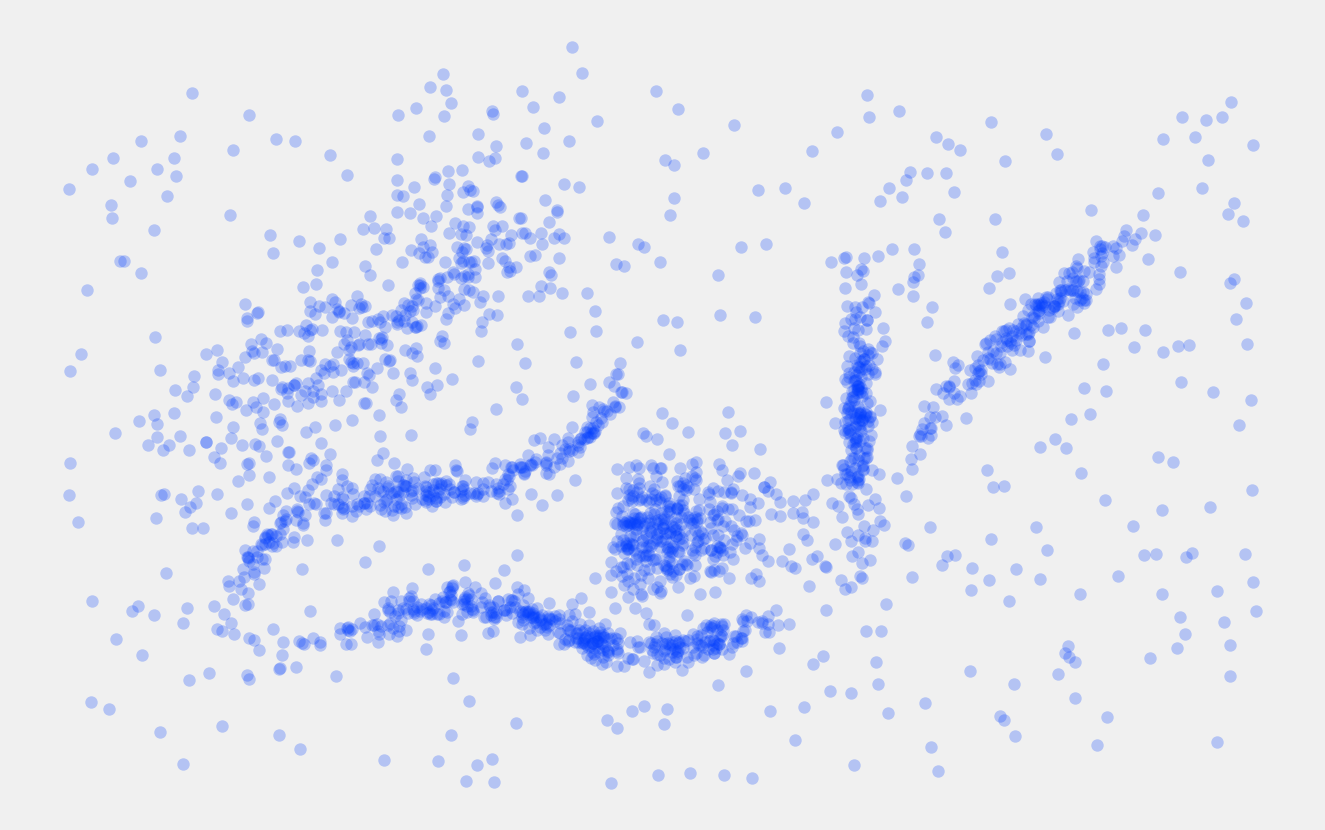

In [5]:
# Visualizing the data
plt.scatter(data.T[0], data.T[1], c='b', **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)

We can definitely identify some clusters even if the data is quite noisy in some parts. To make things more interesting, some clusters are clearly elongated and drawing clear boundaries is difficult. Let's see how the different algorithms will perform when clustering the data. 

## Testing the Algorithms

Hopefully you remember the accronym DRY. We don't want to write the same code for testing the different algorithms over and over again. Therefore we'll define a utility function that does the clustering and takes the time the algorithm needs as well as visualizes the result.

We need to keep in mind that in real use cases we usually **cannot** look at the data to see if some of the points were assigned to a wrong cluster.

In [6]:
# defining a utility function for testing the clustering algorithms
def plot_clusters(data, algorithm, args, kwds):
    # cluster the data while taking the time the process needs 
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    
    # defining the colors for visual representation
    palette = sns.color_palette('bright', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    
    # plotting the data, removing the axis and adding title and time 
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)

## K-Means

K-Means is probably the most common clustering algorithm. It is fast, easy to understand and you will find an implementation in most of the statistical or machine learning tools you will come across to use at some point.


### How does it work?

The objective of K-Means is simple: group similar data points together to a fixed number (*k*) of clusters. Besides the data the only thing the algorithm needs as an input is the number of clusters *k*. *K* in this case can also be seen as the number of centroids, with a centroid being the imaginary or real location representing the cluster center.

The algorithm aims to choose centroids that minimise the **inertia**, or **within-cluster sum of squared criterion**:

$$\sum_{i=0}^{n}\min_{\mu_j \in C}(||x_j - \mu_i||^2)$$

It starts with an initial estimate of the centroid locations. The algorithm then iterates between two steps: 

#### 1. Data assignment

Each centroid defines one of the clusters. In this step, each data point is assigned to its nearest centroid, based on the squared Euclidean distance. More formally, if $c_i$ is the collection of centroids in set $C$, then each data point $x$ is assigned to a cluster based on

$$\underset{c_i \in C}{\arg\min} \; dist(c_i,x)^2$$
where dist( · ) is the standard ($L_2$) Euclidean distance. Let the set of data point assignments for each ith cluster centroid be $S_i$.


#### 2. Centroid update       

In this step, the centroids are recomputed. This is done by taking the mean of all data points assigned to that centroid's cluster.

$$c_i=\frac{1}{|S_i|}\sum_{x_i \in S_i x_i}$$

The difference between the old and new centroids are computed and the algorithm repeats the two steps until a stopping criteria is met (i.e., the value is less than a threshold, no data points change clusters, the sum of the distances is minimized, or some maximum number of iterations is reached).


#### Convergence and random initialization

Given enough time this algorithm is guaranteed to converge to a result. The result may be a local minimum (i.e. not necessarily the best possible outcome), meaning that assessing more than one run of the algorithm with randomized starting centroids may give a better outcome.


<img src=https://upload.wikimedia.org/wikipedia/commons/e/ea/K-means_convergence.gif style="width: 500px;" />

### Pros and Cons

#### Limitations

* Inertia makes the assumption that clusters are convex and isotropic, which often is not the case. So the algorithm has problems identifying elongated clusters or manifolds with irregular shapes.
* We need to specify how many clusters we expect. If we don't know which number might be reasonable we have to run the algorithm several times with different *k* values and evaluate each run using for example the variation on intra-cluster vs. inter-cluster distance to find the optimal value for *k*.  

#### Advantages

* K-Means can be exceptionally efficient. This is K-Means big win. It's a simple algorithm and with the right tricks and optimizations there are few algorithms that can compete with K-Means for performance. If you have truly huge data then K-Means might be your only option.


Let's see how the algorithm performs with our data.

/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


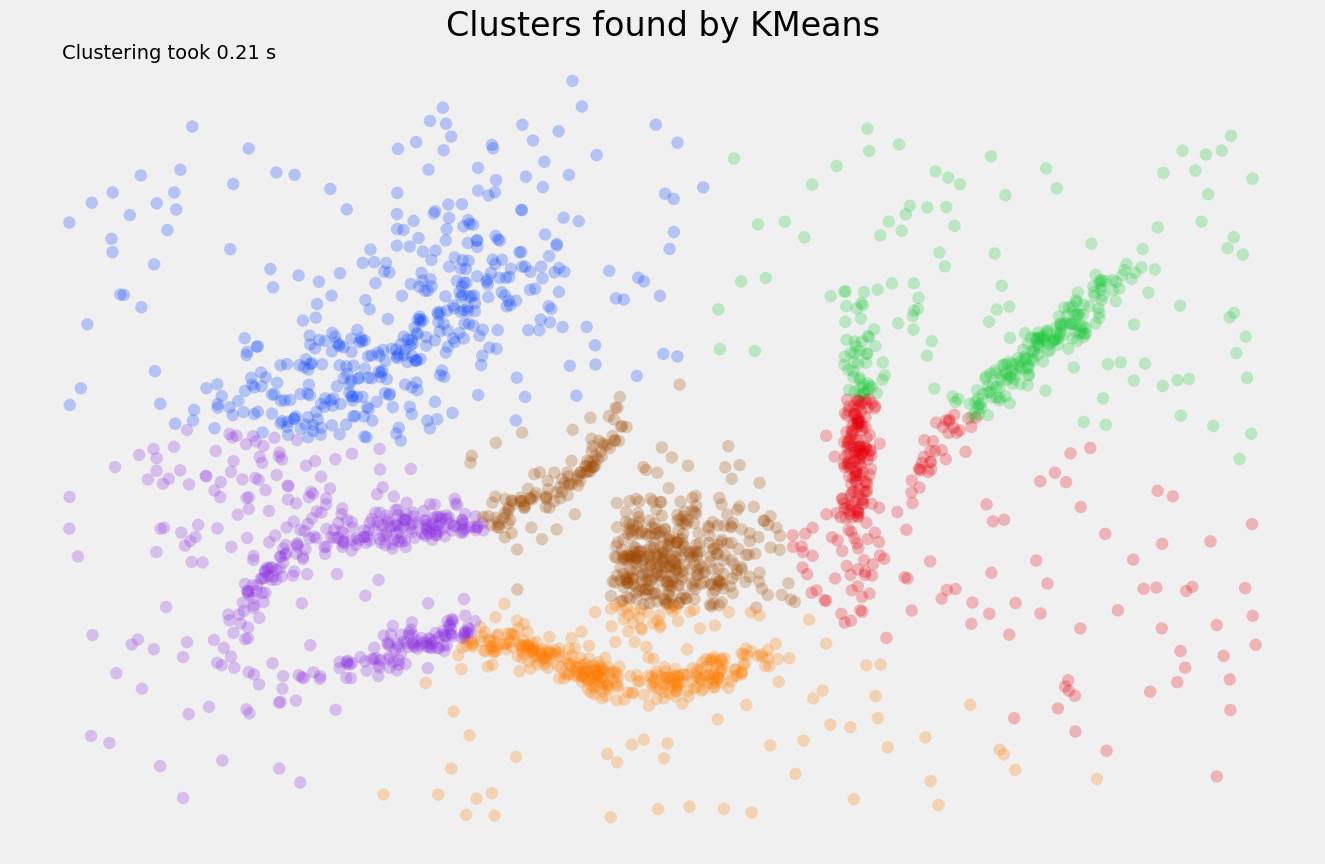

In [7]:
plot_clusters(data, cluster.KMeans, (), {'n_clusters':6})

With the limitations of K-Means in mind the result is not surprising. The assumption of perfectly globular clusters means that the real rather elongated clusters have been poorly identified. What is even worse, the noise points get lumped into clusters as well. In some cases, depending on where the cluster center end up, even relatively distant points are still assigned to a cluster. 

To say something positive as well: K-Means was really quick clustering the data. So at least it's a fast no.

If you want to try out how K-Means performs on different data have a look at this [website](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/) by Naftali Harris. You can choose from a range of different datasets and also decide if you want to set the centroids manually or assign them randomly.

## DBSCAN

DBSCAN is a density based algorithm. It views clusters as areas of high density separated by areas of low density.

It is also the first actual clustering algorithm we've tested so far: it doesn't need to assign every point to a cluster but really extracts the *dense* clusters and leaves the sparse background/noise untouched. K-Means was rather partitioning the data than clustering it. 

Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped. The central component to the DBSCAN is the concept of core samples, which are samples that are in areas of high density. A cluster is therefore a set of core samples, each close to each other (measured by some distance measure) and a set of non-core samples that are close to a core sample (but are not themselves core samples).

The most important hyperparameter we have to specify matching our data is `eps`. Without a proper `eps` DBSCAN will most likely produce unsatisfactory results. With `eps` we can change the maximum distance between samples to be considered in the neighborhood of one another. In order to visualize the effects of `eps` on the clustering performance have a look at this [awesome website](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/) and try out different values. 


![dbscan](https://3.bp.blogspot.com/-rDYuyg00Z0w/WXA-OQpkAfI/AAAAAAAAI_I/QshfNVNHD_wXJwXEipRIVzDSX5iOEAy2wCEwYBhgL/s1600/DBSCAN_Points.PNG)


### Pros and Cons

#### Limitations

* Clusters with varying density can cause problems.
  

#### Advantages

* Clusters don't need to be globular.
* Noise will not be assigned to a cluster.
* It is also stable accross runs and will generate reproducible results. 
* Its very fast and can cluster very large datasets.

Let's check how DBSCAN performs on our data. We choose `eps` to be 0.025 (there is no way to calculate the right value for epsilon, you have to try which works best).

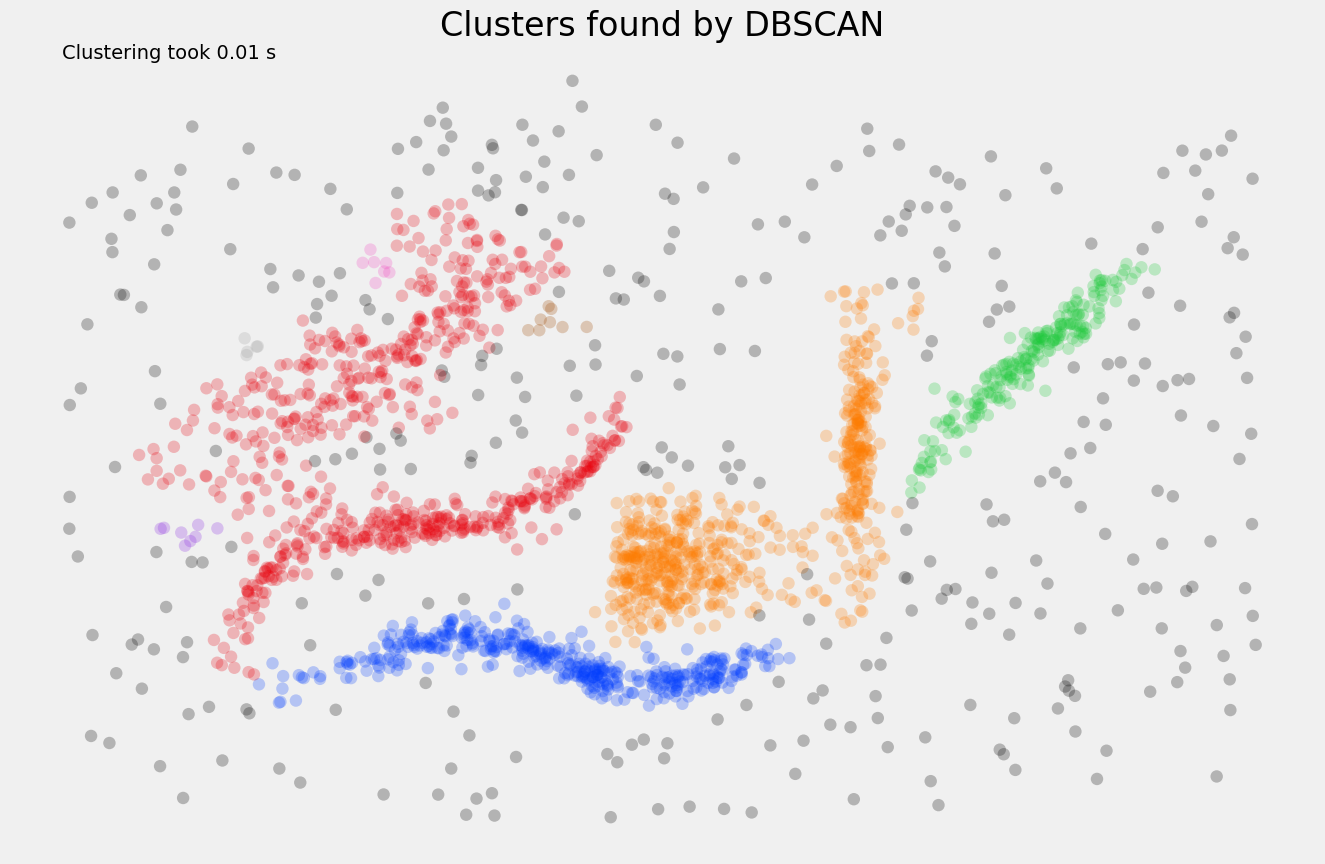

In [8]:
plot_clusters(data, cluster.DBSCAN, (), {'eps':0.025})

This looks pretty decent. The algorthm identified several natural clusters (also the elongated ones) and didn't assign additional noise to those clusters. It didn't perform so well on the rather sparse cluster and defined some tiny additional clusters. That's due to its limited abitilty to handle variable density clusters. All in all the algorithm is doing a decent job.